<a href="https://colab.research.google.com/github/jeniferwerthman/AdvAILSTM/blob/main/Copy_of_LSTMStock_Take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [703]:
!pip install -q yfinance

In [704]:
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader.data import DataReader

import yfinance as yf

import matplotlib.pyplot as mplot
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates

import altair as alt 
from altair import datum

import numpy as np 
from datetime import datetime as dt
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [705]:
#Import Data 
stockTypes = ['TSLA','AAPL', 'GOOG', 'MSFT', 'AMZN', 'DELL', 'INTC', 'NVDA', 'AMD', 'PYPL', 'EBAY']

#Import from API
end = dt.now()
start = dt(end.year - 4, end.month, end.day)
for stockDf in stockTypes:
    globals()[stockDf] = yf.download(stockDf, start, end)

number_of_days = end - start
us_bd = np.busdaycalendar
datelist_past = pd.date_range(start, end, freq='C').tolist()    

#Add Name
stocks = [TSLA, AAPL, GOOG, MSFT, AMZN, DELL, INTC, NVDA, AMD, PYPL, EBAY]
company_name = ["TESLA", "APPLE", "GOOGLE", "MICROSOFT", "AMAZON", "DELL", "INTEL", "NVIDIA", "AMD", "PAYPAL", "EBAY"]

#Make date part of dataset
for stock in stocks:
  stock["Date"] = stock.index
  stock = stock[["Date", "Open", "High", 
              "Low", "Close", "Adj Close", "Volume"]]
  stock.reset_index(drop=True, inplace=True)
  print(stock.head(2))

#Additional Columns
for stock, name in zip(stocks, company_name):
    stock["company_name"] = name

for stock in stocks:
    stock['openChange'] = stock.Open.pct_change()
    stock['closeChange'] = stock.Close.pct_change()
    stock['volumeChange'] = stock.Volume.pct_change() 
    stock['weekday_num'] = pd.DatetimeIndex(stock['Date']).weekday
    stock['month'] = pd.DatetimeIndex(stock['Date']).month
    stock['day'] = pd.DatetimeIndex(stock['Date']).day
    stock['year'] = pd.DatetimeIndex(stock['Date']).year
    stock['display'] = stock["month"].map(str)+ "-" + stock["year"].map(str)

# Select features (columns) to be involved intro training and predictions
cols = list(stocks[1])[0:1]
#cols.pop(1) #Delete middle column

#Forcasting Stock
stockDf = stocks[3] #AAPL

print('Training set shape == {}'.format(stocks[1].shape))
print('Featured selected: {}'.format(cols))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
        Date   Open       High        Low      Close  Adj Close    Volume
0 2018-05-07  59.50  61.192001  59.034000  60.554001  60.554001  43391000
1 2018-05-08  60.16  61.549999  59.799999  60.394001  60.394001  29650000
        Date       

In [706]:
stocks[2].head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-05-07  1049.229980  1061.680054  1047.099976  1054.790039  1054.790039   
2018-05-08  1058.540039  1060.550049  1047.145020  1053.910034  1053.910034   
2018-05-09  1058.099976  1085.439941  1056.364990  1082.760010  1082.760010   
2018-05-10  1086.030029  1100.439941  1085.640015  1097.569946  1097.569946   
2018-05-11  1093.599976  1101.329956  1090.910034  1098.260010  1098.260010   

             Volume       Date company_name  openChange  closeChange  \
Date                                                                   
2018-05-07  1466100 2018-05-07       GOOGLE         NaN          NaN   
2018-05-08  1217700 2018-05-08       GOOGLE    0.008873    -0.000834   
2018-05-09  2032800 2018-05-09       GOOGLE   -0.000416     0.027374   
2018-05-10  1443000 2018-05-10       GOOGLE    0.026396     0.013678   
2018-05-11  1253700 2018-05-11       GOOGLE    0.006970     0.000629   

            volumeChange  weekday_num  month  day  year display  
Date                                                             
2018-05-07           NaN            0      5    7  2018  5-2018  
2018-05-08     -0.169429            1      5    8  2018  5-2018  
2018-05-09      0.669377            2      5    9  2018  5-2018  
2018-05-10     -0.290142            3      5   10  2018  5-2018  
2018-05-11     -0.131185            4      5   11  2018  5-2018

In [707]:
DELL.head()

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2018-05-07  20.486984  20.795692  20.293341  20.343857  20.202341  2057770   
2018-05-08  20.352276  20.352276  19.936922  20.209146  20.068569  5340225   
2018-05-09  20.284922  20.669401  20.225985  20.408403  20.266439  5428237   
2018-05-10  20.461725  21.163336  20.447695  20.961271  20.815462  4681738   
2018-05-11  20.950047  20.958466  20.725531  20.857433  20.712345  3411800   

                 Date company_name  openChange  closeChange  volumeChange  \
Date                                                                        
2018-05-07 2018-05-07         DELL         NaN          NaN           NaN   
2018-05-08 2018-05-08         DELL   -0.006575    -0.006622      1.595152   
2018-05-09 2018-05-09         DELL   -0.003309     0.009860      0.016481   
2018-05-10 2018-05-10         DELL    0.008716     0.027090     -0.137521   
2018-05-11 2018-05-11         DELL    0.023865    -0.004954     -0.271254   

            weekday_num  month  day  year display  
Date                                               
2018-05-07            0      5    7  2018  5-2018  
2018-05-08            1      5    8  2018  5-2018  
2018-05-09            2      5    9  2018  5-2018  
2018-05-10            3      5   10  2018  5-2018  
2018-05-11            4      5   11  2018  5-2018

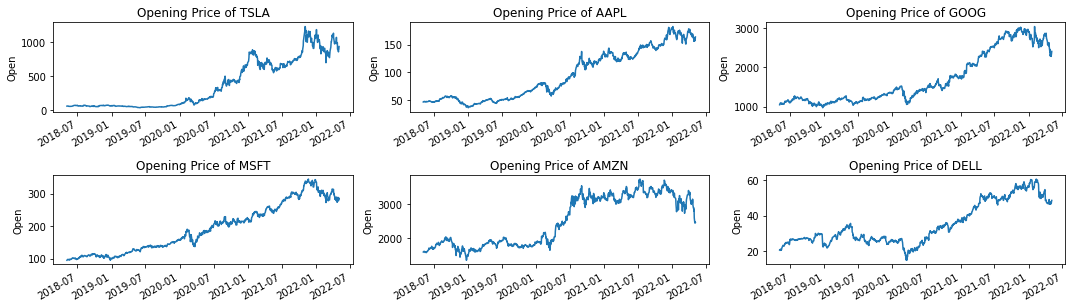

In [708]:
#Opening Graph
mplot.figure(figsize=(15, 6))
mplot.subplots_adjust(top=1.25, bottom=1)

for i, stock in enumerate(stocks[0:6], 1):
    mplot.subplot(3, 3, i)
    stock['Open'].plot()
    mplot.ylabel('Open')
    mplot.xlabel(None)
    mplot.title(f"Opening Price of {stockTypes[i - 1]}")
    
mplot.tight_layout()

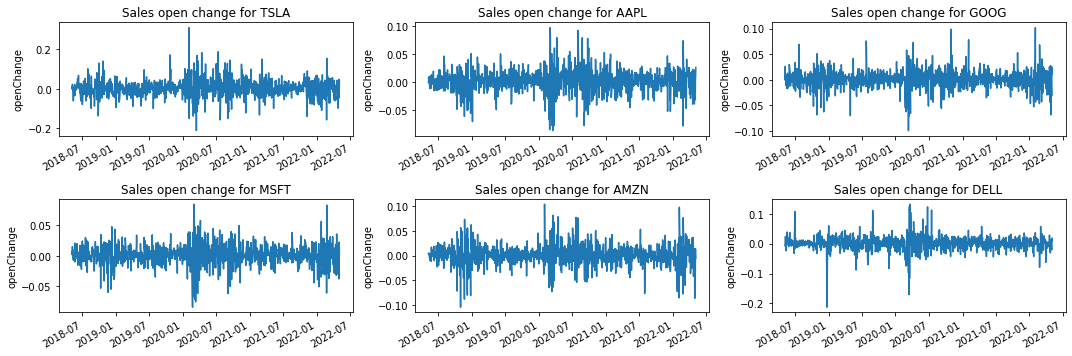

In [709]:
#Change Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks[0:6], 1):
    mplot.subplot(3, 3, i)
    stock['openChange'].plot()
    mplot.ylabel('openChange')
    mplot.xlabel(None)
    mplot.title(f"Sales open change for {stockTypes[i - 1]}")
    
mplot.tight_layout()

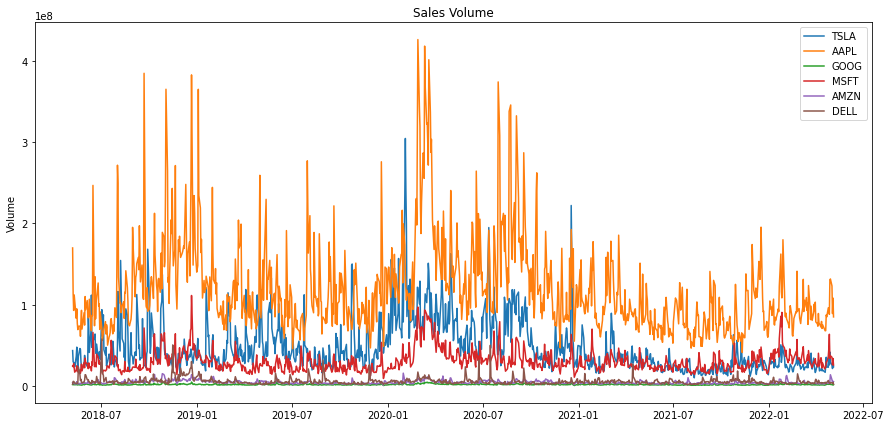

In [710]:
mplot.figure(figsize=(15, 7))
mplot.title(f"Sales Volume")
for i, stock in enumerate(stocks[0:6], 1):
  mplot.plot(stock['Volume'], label = stockTypes[i - 1]) 
  
mplot.ylabel('Volume')
mplot.xlabel(None)
mplot.legend()
mplot.show()  

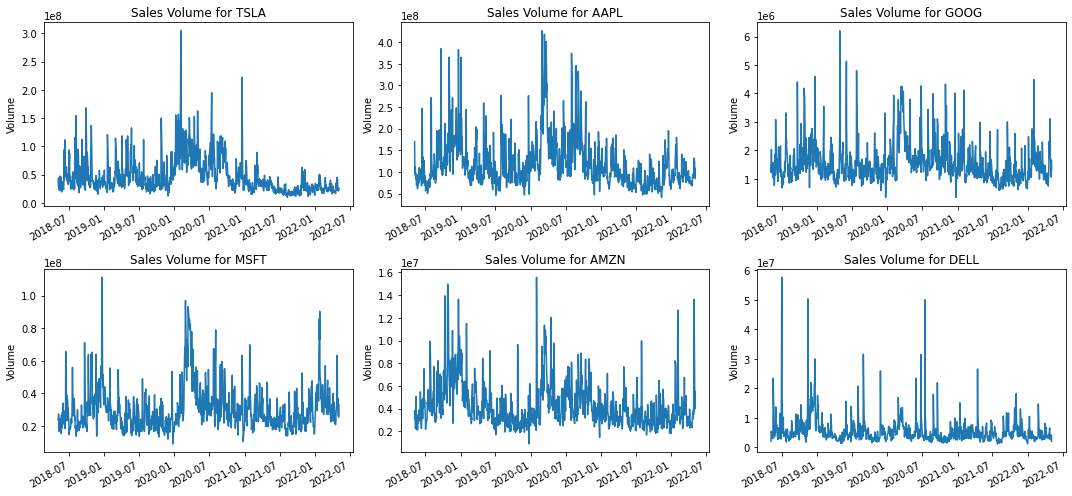

In [711]:
#Volume Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks[0:6], 1):
    mplot.subplot(2, 3, i)
    stock['Volume'].plot()
    mplot.ylabel('Volume')
    mplot.xlabel(None)
    mplot.title(f"Sales Volume for {stockTypes[i - 1]}")
    
mplot.tight_layout()

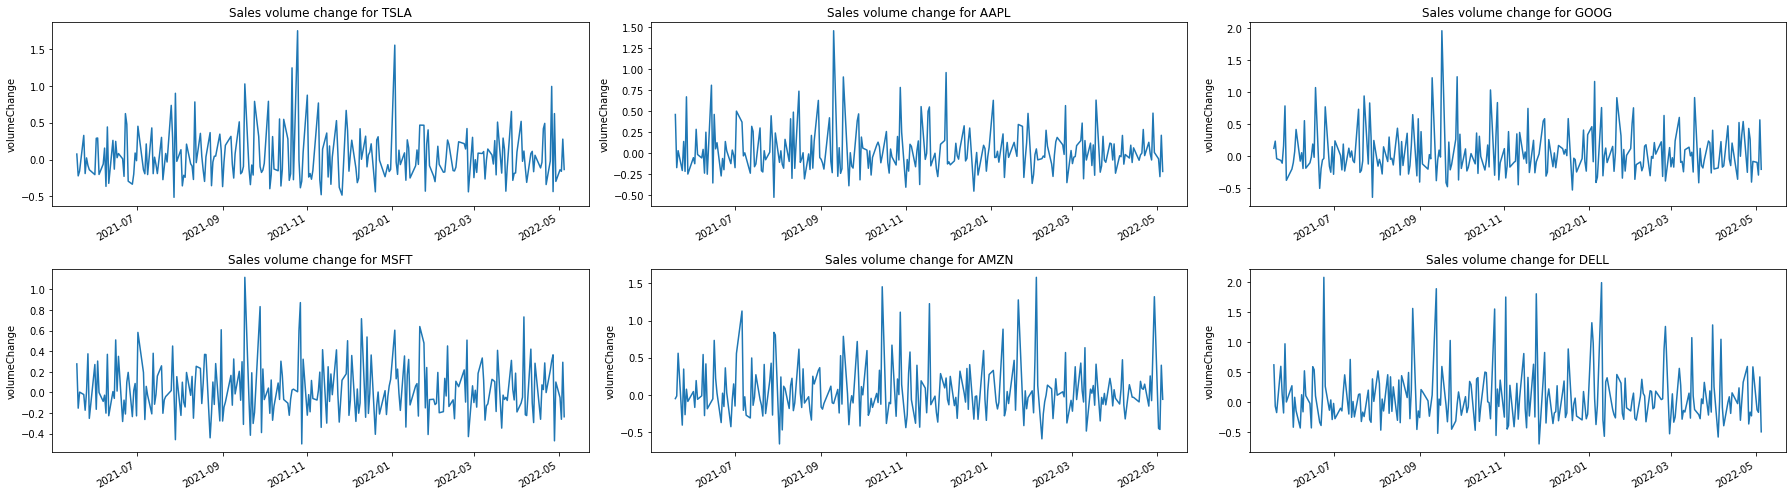

In [712]:
#Volume Change Graphs
mplot.figure(figsize=(25, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks[0:6], 1):
    mplot.subplot(2, 3, i)
    stock['volumeChange'][-244:].plot()
    mplot.ylabel('volumeChange')
    mplot.xlabel(None)
    mplot.title(f"Sales volume change for {stockTypes[i - 1]}")
    
mplot.tight_layout()

In [713]:
def plotIt(i = 0):
  chart = alt.Chart(stocks[i], title=company_name[i]).mark_bar().encode(
          x='day',
          y='Volume',
          column='month',
          color='year')
  return chart

In [714]:
plotIt(1)

alt.Chart(...)

In [715]:
plotIt(2)

alt.Chart(...)

In [716]:
plotIt(3)

alt.Chart(...)

In [717]:
plotIt(4)

alt.Chart(...)

In [718]:
plotIt(5)

alt.Chart(...)

In [719]:
plotIt(6)

alt.Chart(...)

In [720]:
plotIt(7)

alt.Chart(...)

In [721]:
plotIt(8)

alt.Chart(...)

In [722]:
plotIt(9)

alt.Chart(...)

In [723]:
def plotLines(i = 1, stock = None, yValue='max(Volume)'):
   iV = (alt.Chart(stock, title=company_name[i-1]).transform_filter(datum.month==3).
          mark_line().
          encode(x=alt.X('day', sort=['year', 'month']), y=yValue, color='year').
          properties(height=200  , width=500)) 
   return iV

In [724]:
plotLines(3,stockDf,'max(volumeChange)')

alt.Chart(...)

In [725]:
plotLines(3, stockDf)

alt.Chart(...)

In [726]:
#Get Desired columns to train
print('Featured selected: {}'.format(cols))
stockDf = stockDf[cols].astype(str)
for i in cols:
    for j in range(0, len(stockDf)):
        stockDf[i][j] = stockDf[i][j].replace(',', '')

stockDf = stockDf.astype(float)

# Using multiple features (predictors) 
fromRecord = -100
toRecord = None
newDf = stockDf[fromRecord:toRecord]
myDs = newDf.to_numpy() 
myDs = myDs.astype('float32')
print('Shape of training set == {}.'.format(newDf.shape))
newDf[1:5]

Featured selected: ['Open']
Shape of training set == (100, 1).


Open
Date                  
2021-12-14  333.220001
2021-12-15  328.609985
2021-12-16  335.709991
2021-12-17  320.880005

In [727]:
#Parameters
trainingSet = .70
featureRange1 = 0
featureRange2 = 1
newShape1 = -1
newShape2 = 1 

myDs = np.reshape(myDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
myDs = scaler.fit_transform(myDs)
trainingSize = int(len(myDs) * trainingSet)
testingSize = int(len(myDs) - trainingSize)
trainData, testData = myDs[0:trainingSize,:], myDs[testingSize:len(myDs),:]


In [728]:
#Parameters
batchSize = 5
timeSteps = 1
#Batch Data for optimization and accuracy
#This creates batches with 1 to N records.  
#X - Each Batch starts with the next item i in the list and contains specified number of additional items
#Y - Contains the last item in each batch "L" or first "F" or previious "P" or next "N"
def batchData(data, size, indexAlignment = "L"):
    X, Y = [], [] 
    for i in range(len(data) - size - 1): 
        X.append(data[i:(i + size), 0])
         
        if indexAlignment == "N":
          Y.append(data[i + size, 0])
        elif indexAlignment == "L":
          Y.append(data[i + size - 1, 0])
        elif indexAlignment == "P":  
          Y.append(data[i-1, 0])
        else:
          Y.append(data[i, 0]) 

    return np.array(X), np.array(Y)

#Catch Batches for Accuracy and Optimization
X_train, Y_train = batchData(trainData, batchSize, "L")
X_test, Y_test = batchData(testData, batchSize,"L")

#Reshape data to normalize it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], timeSteps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], timeSteps, X_test.shape[1]))

In [729]:
#Parameters
verboseAmt = 1
epochCnt = 100
shuffleData = False
dropOut = 0.2
lstmActivation = 'relu' #'relu'
activationLayer = 'linear'
lossType = 'mean_squared_error'
optimizerType = 'adam'
lstmUnits = 50
lstmMultipleLayers = False

model = Sequential()

if lstmMultipleLayers:
  model.add(LSTM(units = lstmUnits, return_sequences = True, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize)))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits))
  model.add(Dropout(dropOut))
else:
  model.add(LSTM(units = lstmUnits, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize))) 
  model.add(Dropout(dropOut))

model.add(Dense(1, activation = activationLayer))
model.compile(loss = lossType, optimizer = optimizerType)
modelFit = model.fit(X_train, Y_train, epochs = epochCnt, batch_size = batchSize, validation_data = (X_test, Y_test), verbose = verboseAmt, shuffle = False)
model.summary()

Epoch 1/100
13/13 [==============================] - 5s 71ms/step - loss: 0.2867 - val_loss: 0.1035
Epoch 2/100
13/13 [==============================] - 0s 16ms/step - loss: 0.2320 - val_loss: 0.0799
Epoch 3/100
13/13 [==============================] - 0s 19ms/step - loss: 0.1867 - val_loss: 0.0590
Epoch 4/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1441 - val_loss: 0.0409
Epoch 5/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0979 - val_loss: 0.0262
Epoch 6/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0690 - val_loss: 0.0165
Epoch 7/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0463 - val_loss: 0.0115
Epoch 8/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0259 - val_loss: 0.0101
Epoch 9/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0216 - val_loss: 0.0106
Epoch 10/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0171 - val_loss: 0.0114

In [730]:
#Predictions
train_predict = model.predict(X_train)
Y_trained_predict = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)
Y_test_predict = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

s1 = Y_test.shape[0]
s2 = Y_test.shape[1]

Y_test = Y_test.reshape(s2,s1)
Y_train = Y_train.reshape(s2,s1)

In [731]:
print('X_train: ' + str(len(X_train)))
print('X_test: ' + str(len(X_test)))
print('Y_train: ' + str(len(Y_train)))
print('Y_test: ' + str(len(Y_test)))
print('X Train Shape' + str(X_train.shape))
print('Y Train Shape' + str(Y_train.shape))
print('X Test Shape' + str(X_test.shape))
print('Y Test Shape' + str(Y_test.shape))
print('train_predict: ' + str(len(train_predict)))
print('Y_trained_predict: ' + str(len(Y_trained_predict)))
print('test_predict: ' + str(len(test_predict)))
print('Y_test_predict: ' + str(len(Y_test_predict)))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:' + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))

X_train: 64
X_test: 64
Y_train: 64
Y_test: 64
X Train Shape(64, 1, 5)
Y Train Shape(64, 1)
X Test Shape(64, 1, 5)
Y Test Shape(64, 1)
train_predict: 64
Y_trained_predict: 64
test_predict: 64
Y_test_predict: 64
Shape of Y_train:64
Shape of Y_train:64
Shape of Y_train:64
Shape of Y_train:64


In [732]:
#Calculate Accuracy
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_trained_predict))
test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_predict))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
3.0566998059146213 

Test RMSE is: 
2.987116228140568


In [733]:
#Actual vs Predicted Data
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_trained_predict, Y_test_predict)
result_df = pd.DataFrame()
result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
result_df.head()

Actual_Y  Predicted_Y
0  320.880010   323.937653
1  320.049974   321.188293
2  323.290016   321.071747
3  328.299971   324.838257
4  332.750001   327.662262

Text(0, 0.5, 'Value of Stock')

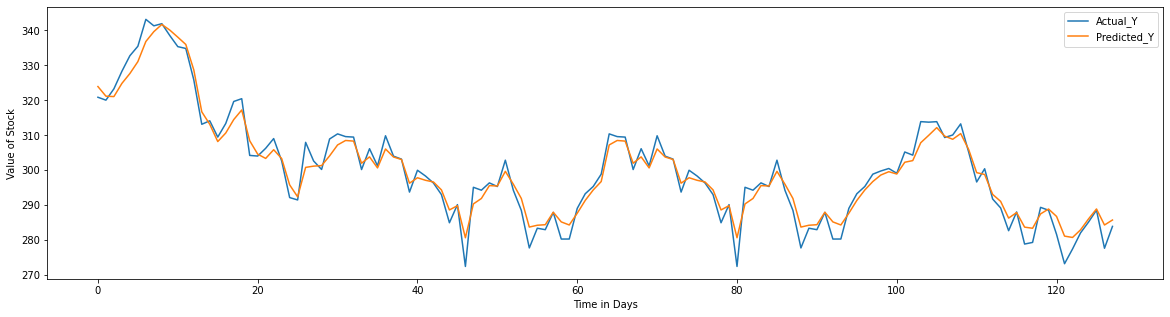

In [734]:
#Actual vs Predicted Graph
result_df.plot(figsize=(20,5))
mplot.xlabel('Time in Days')
mplot.ylabel('Value of Stock')

In [781]:
from pandas.tseries.offsets import BDay

#Prediction Forcastings
predictionCount = 9
lookback =30 
yesterday = end - timedelta(days=1)
trainingStartDate = (end - BDay(lookback)).to_pydatetime()
forcastingTrainingDays = yesterday - trainingStartDate
datelist_future = pd.date_range(end, periods=predictionCount, freq='C').tolist()  
datelist_Training = pd.date_range(end=end, periods=lookback, freq='C').tolist() 

y_past_training = model.predict(X_train[-lookback-1:])
print(len(y_past_training))
y_past_training_values = scaler.inverse_transform(y_past_training[0:lookback])
print('y_past_training_values with X_train: ')
print(y_past_training_values[-5:])

y_future_prediction = model.predict(X_train[-predictionCount:])
y_future_prediction_values = scaler.inverse_transform(y_future_prediction)
print('y_future_prediction_values with X_train: ')
y_future_prediction_values1=scaler.inverse_transform(y_future_prediction_values)

print(y_future_prediction_values[:5])
print(len(y_past_training_values))
print(len(datelist_training))

#Look Back prediction
PREDICTIONS_FUTURE = pd.DataFrame(y_future_prediction_values, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_past_training_values, columns=['Open']).set_index(pd.Series(datelist_training)) 
PREDICTIONS_FUTURE.head(11)

31
y_past_training_values with X_train: 
[[276.1944 ]
 [275.99377]
 [276.75983]
 [277.5948 ]
 [278.27582]]
y_future_prediction_values with X_train: 
[[275.9763 ]
 [276.01114]
 [276.82553]
 [276.1944 ]
 [275.99377]]
30
30


Open
2022-05-05 18:53:42.530772  275.976288
2022-05-06 18:53:42.530772  276.011139
2022-05-09 18:53:42.530772  276.825531
2022-05-10 18:53:42.530772  276.194397
2022-05-11 18:53:42.530772  275.993774
2022-05-12 18:53:42.530772  276.759827
2022-05-13 18:53:42.530772  277.594788
2022-05-16 18:53:42.530772  278.275818
2022-05-17 18:53:42.530772  278.825623

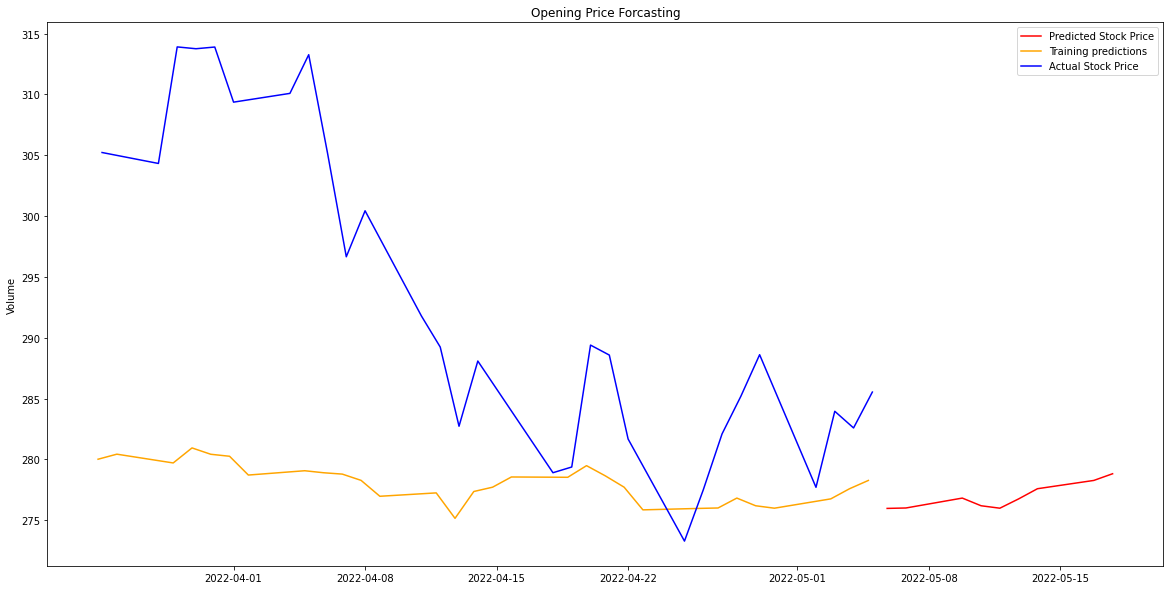

In [782]:
mplot.figure(figsize=(20,10))
mplot.title(f"Opening Price Forcasting")
mplot.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
mplot.plot(PREDICTION_TRAIN.loc[trainingStartDate:].index, PREDICTION_TRAIN.loc[trainingStartDate:]['Open'], color='orange', label='Training predictions')
mplot.plot(stockDf.loc[trainingStartDate:].index, stockDf.loc[trainingStartDate:]['Open'], color='b', label='Actual Stock Price')
mplot.ylabel('Volume')
mplot.xlabel(None)
mplot.legend()
mplot.show() 

In [783]:
#Prediction Forcastings take 2- using different sample of data than used above
forcastingDays = 9
lookback =15
trainingStartDate = end - timedelta(days=lookback)
datelist_future = pd.date_range(end, periods=forcastingDays, freq='C').tolist() 
datelist_Training = pd.date_range(end=end, periods=lookback, freq='C').tolist() 
print('End date: ' + str(end))
print('Training start date: ' + str(trainingStartDate))
print('datelist_future: ')
print(datelist_future)
print('datelist_Training: ')
print(datelist_Training) 

predictMeData = stockDf[-lookback:] 
predictionDs = predictMeData.to_numpy() 
predictionDs = predictionDs.astype('float32')

predictionDs = np.reshape(predictionDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
predictionDs = scaler.fit_transform(predictionDs)  
forcastingTrainingValues = predictionDs[0:lookback,:] 

XX, YY = batchData(forcastingTrainingValues, batchSize, "L")
XX = np.reshape(XX, (XX.shape[0], timeSteps, XX.shape[1]))
forcastingValues = model.predict(XX)

y_future_values = scaler.inverse_transform(forcastingValues)
y_future_values

End date: 2022-05-05 18:53:42.530772
Training start date: 2022-04-20 18:53:42.530772
datelist_future: 
[Timestamp('2022-05-05 18:53:42.530772', freq='C'), Timestamp('2022-05-06 18:53:42.530772', freq='C'), Timestamp('2022-05-09 18:53:42.530772', freq='C'), Timestamp('2022-05-10 18:53:42.530772', freq='C'), Timestamp('2022-05-11 18:53:42.530772', freq='C'), Timestamp('2022-05-12 18:53:42.530772', freq='C'), Timestamp('2022-05-13 18:53:42.530772', freq='C'), Timestamp('2022-05-16 18:53:42.530772', freq='C'), Timestamp('2022-05-17 18:53:42.530772', freq='C')]
datelist_Training: 
[Timestamp('2022-04-15 18:53:42.530772', freq='C'), Timestamp('2022-04-18 18:53:42.530772', freq='C'), Timestamp('2022-04-19 18:53:42.530772', freq='C'), Timestamp('2022-04-20 18:53:42.530772', freq='C'), Timestamp('2022-04-21 18:53:42.530772', freq='C'), Timestamp('2022-04-22 18:53:42.530772', freq='C'), Timestamp('2022-04-25 18:53:42.530772', freq='C'), Timestamp('2022-04-26 18:53:42.530772', freq='C'), Timestam

array([[286.46777],
       [284.03583],
       [276.74954],
       [276.65988],
       [279.19113],
       [281.91013],
       [283.86108],
       [280.8983 ],
       [282.76248]], dtype=float32)

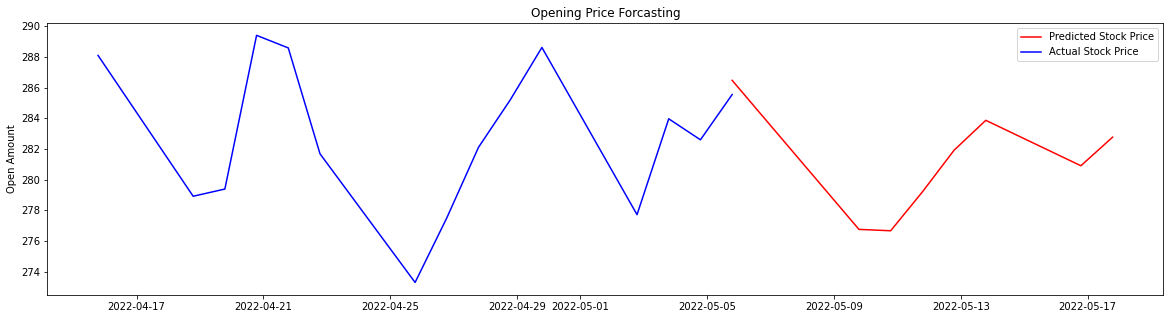

In [785]:
G = stockDf[-lookback:] 
G = predictMeData.to_numpy() 
mplot.figure(figsize=(20,5))
mplot.title(f"Opening Price Forcasting")
mplot.plot(datelist_future, y_future_values, color='r', label='Predicted Stock Price') 
mplot.plot(datelist_Training[-15:], G, color='b', label='Actual Stock Price')
mplot.ylabel('Open Amount')
mplot.xlabel(None)
mplot.legend()
mplot.show() 

In [775]:
end

datetime.datetime(2022, 5, 5, 18, 53, 42, 530772)

In [776]:
timedelta(days=lookback)

datetime.timedelta(days=15)

In [777]:
end - timedelta(days=lookback)

datetime.datetime(2022, 4, 20, 18, 53, 42, 530772)